# 1. Generate images set out of an LROC NAC DEM (5 m/pix)
Initialize workspace: 

In [1]:
import sys
import os
sys.path.append('../')
from PIL import Image
import time
Image.MAX_IMAGE_PIXELS = 353894500
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import input_data_gen as igen
import utils.processing as proc
import h5py
import utils.maplot
np.random.seed(42)

data_path='../../data/'

In [2]:
# Download file:
# fn_pre='NAC_DTM_AESTUUM2'
fn_pre='NAC_DTM_POSIDONIUS'
website = 'http://lroc.sese.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/NAC_DTM/POSIDONIUS/'
# website='http://lroc.sese.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/NAC_DTM/AESTUUM2/'
for fn in [fn_pre+'.TIF', fn_pre+'.LBL']:
    if os.path.isfile(data_path+fn): 
        print('File {} exist in library!'.format(fn))
    else: 
        s_time = time.time()
        print('File {} does not exist in library. downloading now ...'.format(fn))
        URL = website+fn
#         os.sys('wget -P "$data_path" "$URL"')
        !wget -P "$data_path" "$URL"
        print('Downloaded into {}'.format(data_path+fn))
        print("Time elapsed: {0:.1f} sec".format(time.time() - s_time))
        
# Read source image.
img = Image.open(data_path + fn_pre + '.TIF')
print('Original image. size (shape): {} | mode (bit depth): {}'.format(img.size, img.mode))
# dimensions of source image: [Min long, max long, min lat, max lat] 
# read from Label file: 
import re
file = open(data_path + fn_pre+'.LBL','r')
lines = [line.rstrip('\n') for line in file]
for line in lines:
    if 'MAXIMUM_LATITUDE' in line:
        max_lat=float(re.findall("\d+.\d*",line)[0])
    if 'MINIMUM_LATITUDE' in line:
        min_lat=float(re.findall("\d+.\d*",line)[0])
    if 'EASTERNMOST_LONGITUDE' in line:
        max_lon=float(re.findall("\d+.\d*",line)[0])
    if 'WESTERNMOST_LONGITUDE' in line:
        min_lon=float(re.findall("\d+.\d*",line)[0])
    if 'MAP_SCALE' in line:
        res=float(re.findall("\d+.\d*",line)[0])

source_cdim = [min_lon, max_lon, min_lat, max_lat]
print(source_cdim)
print('map resolution: {} m/pix'.format(res))

File NAC_DTM_POSIDONIUS.TIF does not exist in library. downloading now ...
--2019-09-12 11:48:16--  http://lroc.sese.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/NAC_DTM/POSIDONIUS/NAC_DTM_POSIDONIUS.TIF
Resolving lroc.sese.asu.edu (lroc.sese.asu.edu)... 129.219.107.13
Connecting to lroc.sese.asu.edu (lroc.sese.asu.edu)|129.219.107.13|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208424003 (199M) [image/tiff]
Saving to: ‘../../data/NAC_DTM_POSIDONIUS.TIF’

NAC_DTM_POSIDONIUS. 100%[===================>] 198.77M  1.58MB/s    in 2m 6s   

2019-09-12 11:50:23 (1.58 MB/s) - ‘../../data/NAC_DTM_POSIDONIUS.TIF’ saved [208424003/208424003]

Downloaded into ../../data/NAC_DTM_POSIDONIUS.TIF
Time elapsed: 126.3 sec
File NAC_DTM_POSIDONIUS.LBL does not exist in library. downloading now ...
--2019-09-12 11:50:23--  http://lroc.sese.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/NAC_DTM/POSIDONIUS/NAC_DTM_POSIDONIUS.LBL
Resolving lroc.sese.asu.edu (lro

In [3]:
# img=img.rotate(2.8) #rotate to align
start_time = time.time()
img_arr = np.asarray(img) # convert to np 2-d array
s=img_arr.shape
img_vec = np.concatenate(img_arr) # convert to np 1-d array
img_vec[(img_vec<-1e38)] = np.max(img_vec)+4 # replace missing data with a distinct value, which will be transformed to 0
img_arr = np.reshape(img_vec,s) # convert to np 2-d array

#transformation: 
min_val = np.min(img_vec)
dif = (np.max(img_vec)-min_val)
img8 = np.uint8(np.abs(img_arr-min_val)/dif*256)
img = Image.fromarray(img8) # convert 2-d array with nan to PIL.Image

print(time.time() - start_time)
print('Original image. size (shape): {} | mode (bit depth): {}'.format(img.size, img.mode))

2.388362169265747
Original image. size (shape): (3415, 15249) | mode (bit depth): L


Number of unique values: 5425892
Number of unique values: 256


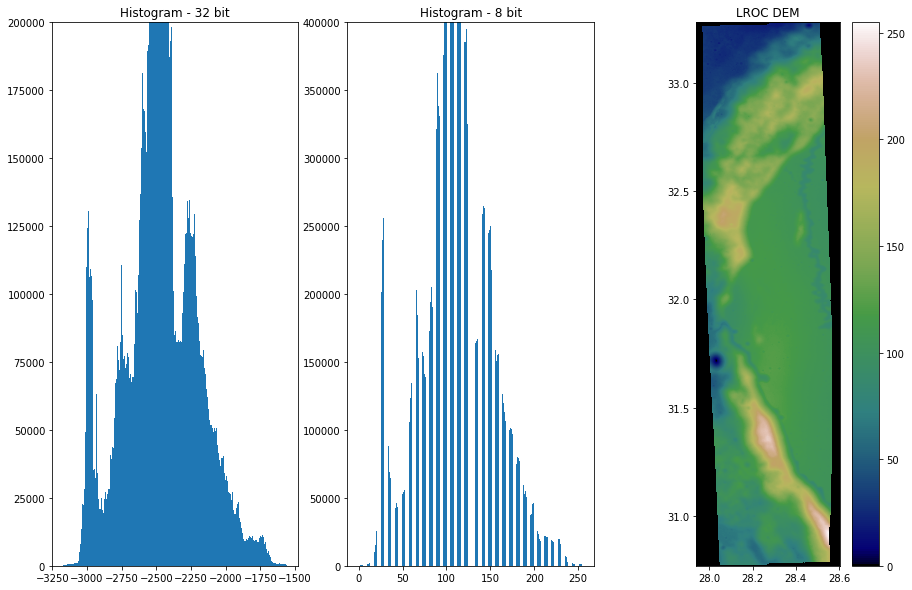

In [4]:
fig = plt.figure(figsize=[15, 10])
plt.subplot(1,3,1)
plt.hist(img_vec,512);
plt.title('Histogram - 32 bit')
plt.ylim([0,200000])
print('Number of unique values: {}'.format(len(np.unique(img_vec))))

plt.subplot(1,3,2)
img8_vec = np.concatenate(img8)
plt.hist(img8_vec,512);
plt.title('Histogram - 8 bit')
plt.ylim([0,400000])
print('Number of unique values: {}'.format(len(np.unique(img8_vec))))

plt.subplot(1,3,3)
plt.imshow(img, extent=source_cdim, aspect="equal", cmap="gist_earth") # show image
plt.colorbar()
plt.title('LROC DEM');

Produce a set with the now 8 bit map:

In [5]:
np.random.seed(42)
# Import crater catalogs (stored under /catalogues)
craters = igen.ReadRobbinsCraterCSV(filename="../catalogues/RobbinsLunarCraters.csv")

fn = data_path + 'test_LROC_8bit'
sub_cdim = source_cdim

# Sample subset of image.  Co-opt igen.ResampleCraters to remove all
# craters beyond cdim (either sub or source).
if sub_cdim != source_cdim:
    img = igen.InitialImageCut(img, source_cdim, sub_cdim)
craters = igen.ResampleCraters(craters, sub_cdim, img.size[1])
craters.tail()
start_time = time.time()

# Generate input images: 
igen.GenDataset(img, craters, fn, 
                 cdim=sub_cdim, amt=10, rawlen_range=[256*2, 2000], seed=42, verbose=True,
               compress16bit=False)

print("Time elapsed: {0:.1f} sec".format(time.time() - start_time))

Generating img_00
Generating img_01
Generating img_02
Generating img_03
Generating img_04
Generating img_05
Generating img_06
Generating img_07
Generating img_08
Generating img_09
Time elapsed: 2.1 sec


Number of unique values: 36


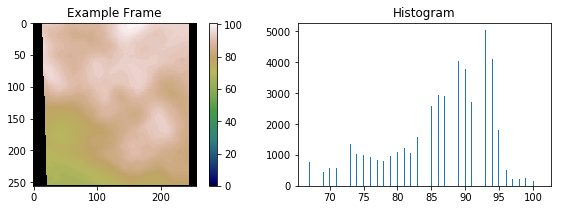

In [6]:
# show one example frmae: 
example = h5py.File(fn + '_images.hdf5', 'r')
im_num=2

fig = plt.figure(figsize=[10, 3])
plt.subplot(1,2,1)
plt.title('Example Frame')
plt.imshow(example['input_images'][im_num], aspect="equal", cmap="gist_earth")
plt.colorbar()
plt.subplot(1,2,2)
img_arr = np.concatenate(example['input_images'][im_num])
plt.hist(img_arr[img_arr>0], 256);
plt.title('Histogram')
print('Number of unique values: {}'.format(len(np.unique(img_arr))))

Produce another set with the original 32-bit map, then transform: 

In [7]:
img = Image.open(data_path + fn_pre + '.TIF')
np.random.seed(42)
# Import crater catalogs (stored under /catalogues)
craters = igen.ReadRobbinsCraterCSV(filename="../catalogues/RobbinsLunarCraters.csv")

fn = data_path + 'test_LROC_32bit'
sub_cdim = source_cdim

# Sample subset of image.  Co-opt igen.ResampleCraters to remove all
# craters beyond cdim (either sub or source).
if sub_cdim != source_cdim:
    img = igen.InitialImageCut(img, source_cdim, sub_cdim)
craters = igen.ResampleCraters(craters, sub_cdim, img.size[1])
craters.tail()
start_time = time.time()

# Generate input images: 
igen.GenDataset(img, craters, fn, 
                 cdim=sub_cdim, amt=10, rawlen_range=[256*2, 2000], seed=42, verbose=True,
               compress32bit=True)

print("Time elapsed: {0:.1f} sec".format(time.time() - start_time))

Generating img_00
Generating img_01
Generating img_02
Generating img_03
Generating img_04
Generating img_05
Generating img_06
Generating img_07
Generating img_08
Generating img_09
Time elapsed: 2.6 sec


Number of unique values: 251


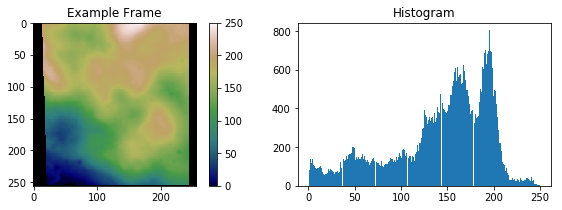

In [8]:
# show one example frmae: 
example = h5py.File(fn + '_images.hdf5', 'r')
im_num=2

fig = plt.figure(figsize=[10, 3])
plt.subplot(1,2,1)
plt.title('Example Frame')
plt.imshow(example['input_images'][im_num], aspect="equal", cmap="gist_earth")
plt.colorbar()
plt.subplot(1,2,2)
img_arr = np.concatenate(example['input_images'][im_num])
plt.hist(img_arr[img_arr>0], 256);
plt.title('Histogram')
print('Number of unique values: {}'.format(len(np.unique(img_arr))))

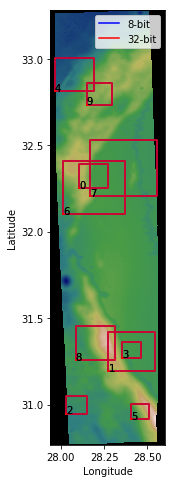

In [10]:
sub_cdim = source_cdim
gen_imgs8 = h5py.File(data_path + 'test_LROC_8bit' + '_images.hdf5', 'r')
gen_imgs32 = h5py.File(data_path + 'test_LROC_32bit' + '_images.hdf5', 'r')

# See frames of the set we produced: 
subset_list = np.arange(10)
fig = plt.figure(figsize=[4, 8])
dem_map = plt.imshow(img, extent=sub_cdim, aspect="equal", cmap="gist_earth", vmin=-3250, vmax=-1500)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
for i in subset_list:
  llon,rlon,llat,ulat=gen_imgs8['longlat_bounds']['img_{:02d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'b')
  plt.text(llon,llat,str(i), color='k')

  llon,rlon,llat,ulat=gen_imgs32['longlat_bounds']['img_{:02d}'.format(i)][...]
  h2,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'r')
  plt.text(llon,llat,str(i), color='k')
    
plt.legend([h1,h2],['8-bit','32-bit']);

In [11]:
# how many unique values in each frame? 
UV=[len(np.unique(gen_imgs8['input_images'][i].flatten())) for i in range(10)]
print('8-bit frames: {}±{:.1f} unique values'.format(np.mean(UV),np.std(UV)))
UV=[len(np.unique(gen_imgs32['input_images'][i].flatten())) for i in range(10)]
print('32-bit frames: {}±{:.1f} unique values'.format(np.mean(UV),np.std(UV)))

8-bit frames: 100.4±42.3 unique values
32-bit frames: 251.9±6.0 unique values


# 2. Test model on frames from new DEM

In [12]:
import keras
keras.__version__

Using TensorFlow backend.


'1.2.2'

In [13]:
from keras.models import load_model
import sys
deepmoon_path='../../DeepCrater'
sys.path.append("%s/utils/"%deepmoon_path)
import template_match_target as tmt
import pandas as pd

# Use the commented out line for Keras 2.0+
# model = load_model(zenodo_path + '/model_keras2.h5')
model = load_model(data_path + '/model_keras1.2.2.h5')

def predict_and_show(gen_imgs, im_num, craters):
    sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
    proc.preprocess(sample_data)
    sd_input_images = sample_data['imgs'][0]
    sd_target_masks = sample_data['imgs'][1]
    pred = model.predict(sd_input_images[im_num:im_num + 1])
    # Use scikit-image template matching to extract crater locations.  Only search for craters with r >= 3 pixels.
    extracted_rings = tmt.template_match_t(pred[0].copy(), minrad=1.5)
    
    fig = plt.figure(figsize=[18, 6])
    [ax1, ax2, ax3] = fig.subplots(1, 3)
    ax1.imshow(sd_input_images[im_num].squeeze(), origin='upper', cmap='gist_earth')
    ax1.imshow(1-sd_target_masks[im_num].squeeze(), origin='upper', cmap='Greys_r', alpha=0.2)
    ax2.imshow(pred[0], origin='upper', cmap='Greys_r', vmin=0, vmax=1)
    ax3.imshow(sd_input_images[im_num].squeeze(), origin='upper', cmap="gist_earth")
    for x, y, r in extracted_rings:
        circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.9)
        ax3.add_artist(circle)
    ax1.set_title('DEM + Ground-Truth')
    ax2.set_title('CNN Predictions')
    ax3.set_title('Post-CNN Craters')
    plt.show()
    sub_cdim=gen_imgs['longlat_bounds']['img_{:02d}'.format(im_num)][...]
    if len(extracted_rings):
        df1=pd.DataFrame(data=extracted_rings, columns=['x','y','r'])
        df1['catalog']='DeepCrater'
        df1['Diameter (m)']=np.ceil(df1['r']*2*(sub_cdim[1]-sub_cdim[0])/256*30*1000).astype(int) #D=2*radius_pix*deg/pix*km/deg
        df2 = igen.ResampleCraters(craters, sub_cdim, 256, minpix=3.)
        df2['Diameter (m)']=np.ceil(df2['Diameter (km)']*1000)
        df2['catalog']='Robbins'
        c=pd.get_dummies(pd.concat([df1[['Diameter (m)','catalog']],df2[['Diameter (m)','catalog']]])).astype(int)
        c=c.pivot_table(index='Diameter (m)',aggfunc=sum, margins=True).astype(int)
        if len(c['catalog_Robbins']):
            c['fraction']=c['catalog_DeepCrater']/c['catalog_Robbins']
        print(c)
    else: 
        print('no craters were found!')

/home/grosman/projectDC/DeepCrater/technical/deep_crater_env/lib/python3.5/site-packages/skimage/feature/template.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


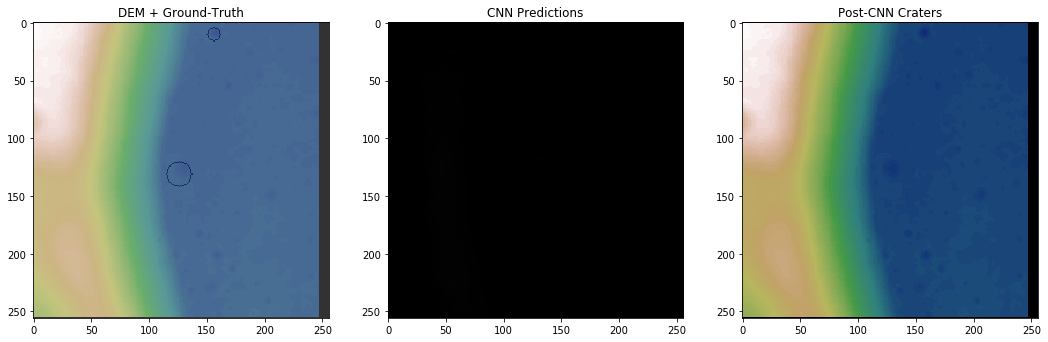

no craters were found!


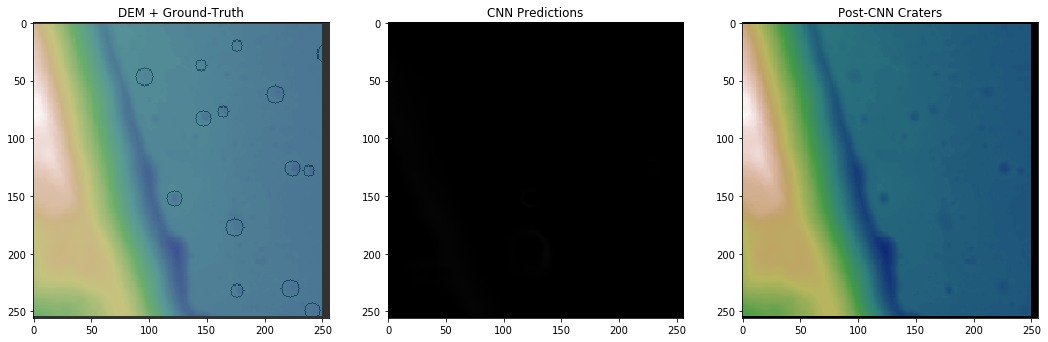

no craters were found!


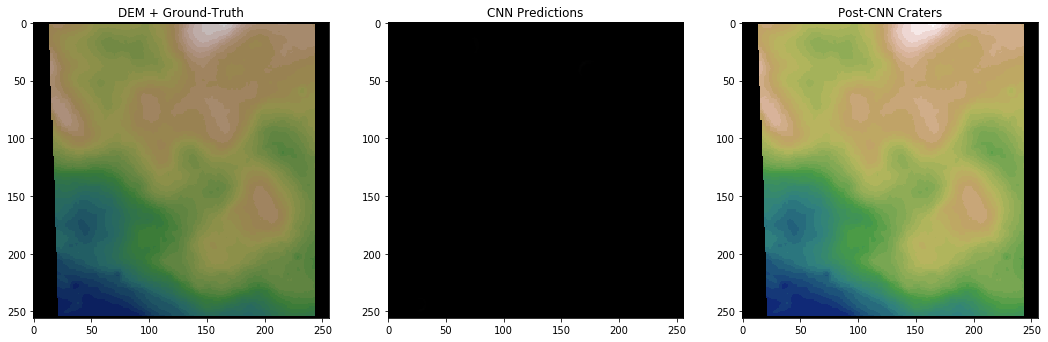

no craters were found!


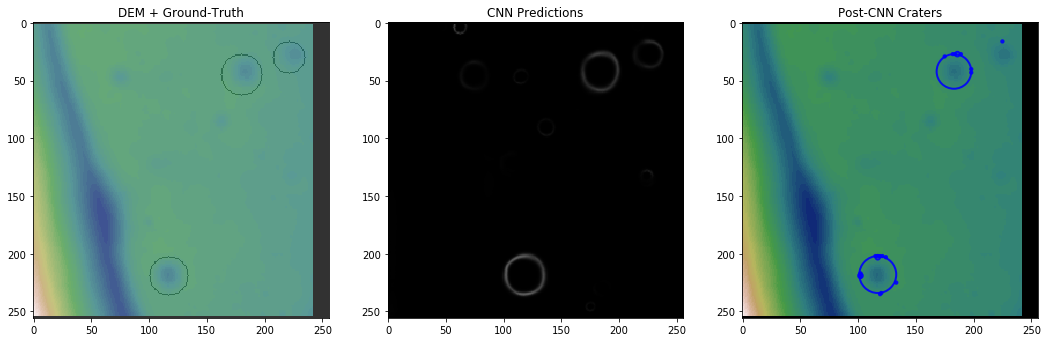

              catalog_DeepCrater  catalog_Robbins  fraction
Diameter (m)                                               
26                            18                0       inf
51                             3                0       inf
294                            0                1  0.000000
366                            0                1  0.000000
379                            1                0       inf
385                            0                1  0.000000
404                            1                0       inf
All                           23                3  7.666667


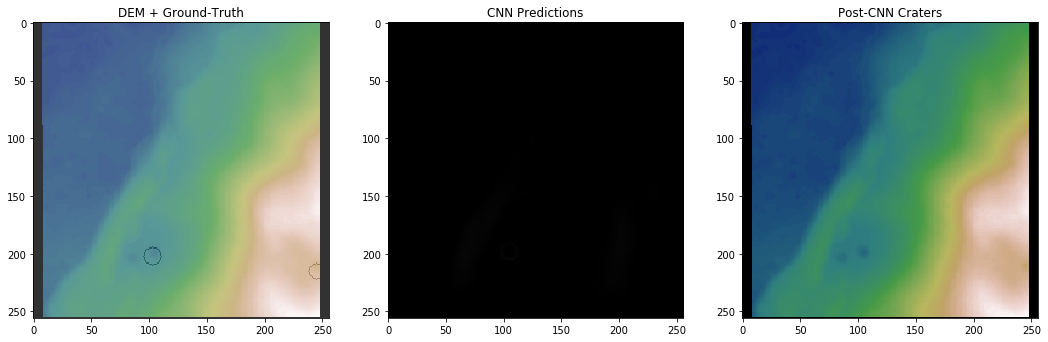

no craters were found!


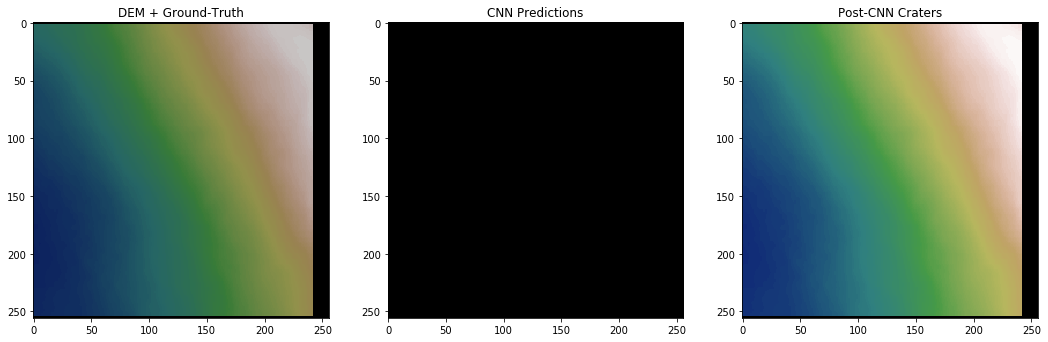

no craters were found!


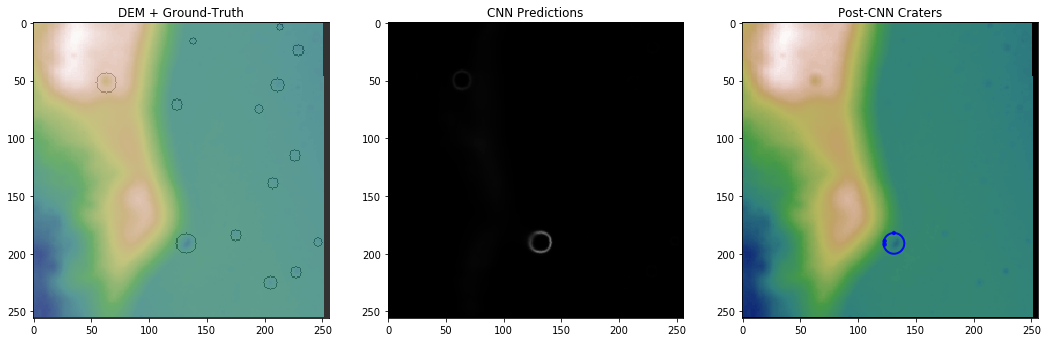

              catalog_DeepCrater  catalog_Robbins  fraction
Diameter (m)                                               
84                             3                0       inf
206                            0                1  0.000000
224                            0                1  0.000000
273                            0                1  0.000000
313                            0                1  0.000000
337                            0                1  0.000000
350                            0                1  0.000000
353                            0                1  0.000000
369                            0                3  0.000000
404                            0                1  0.000000
408                            0                1  0.000000
617                            0                1  0.000000
627                            0                1  0.000000
755                            1                0       inf
All                            4        

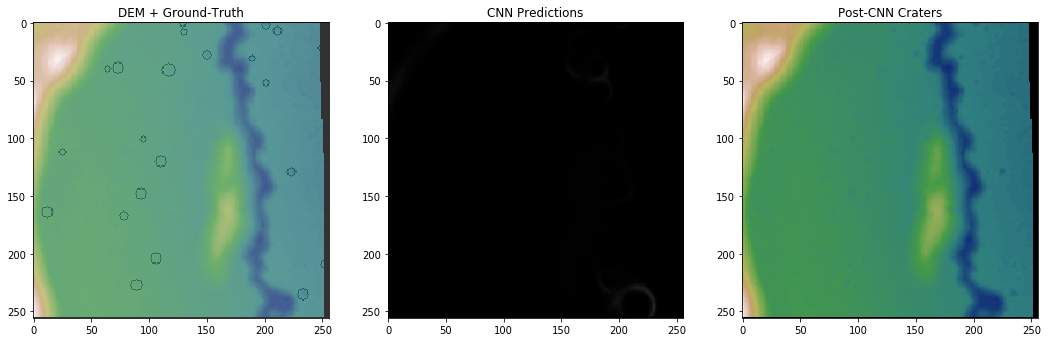

no craters were found!


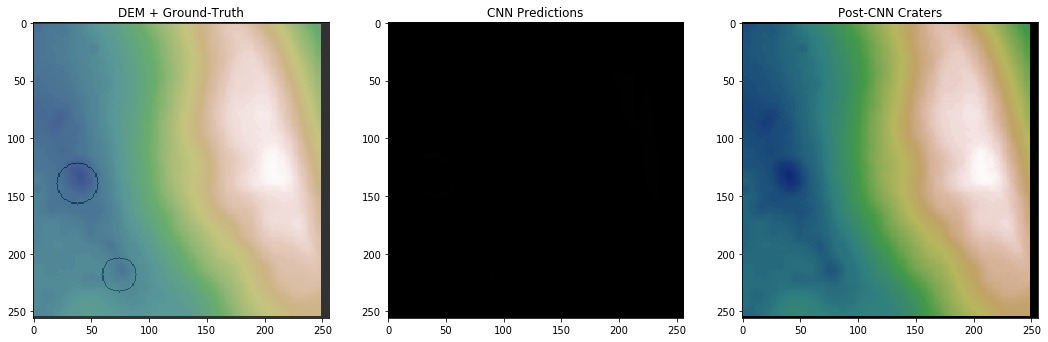

no craters were found!


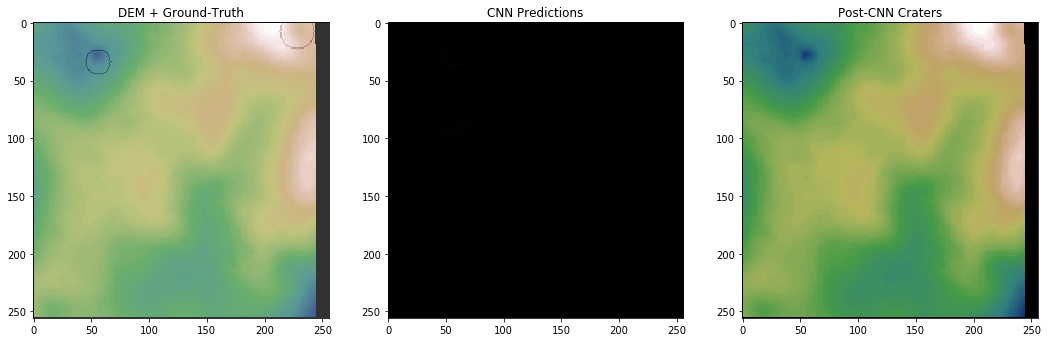

no craters were found!


[None, None, None, None, None, None, None, None, None, None]

In [14]:
craters = igen.ReadRobbinsCraterCSV(filename="../catalogues/RobbinsLunarCraters.csv")
[predict_and_show(gen_imgs8, i, craters) for i in range(10)]

/home/grosman/projectDC/DeepCrater/technical/deep_crater_env/lib/python3.5/site-packages/skimage/feature/template.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


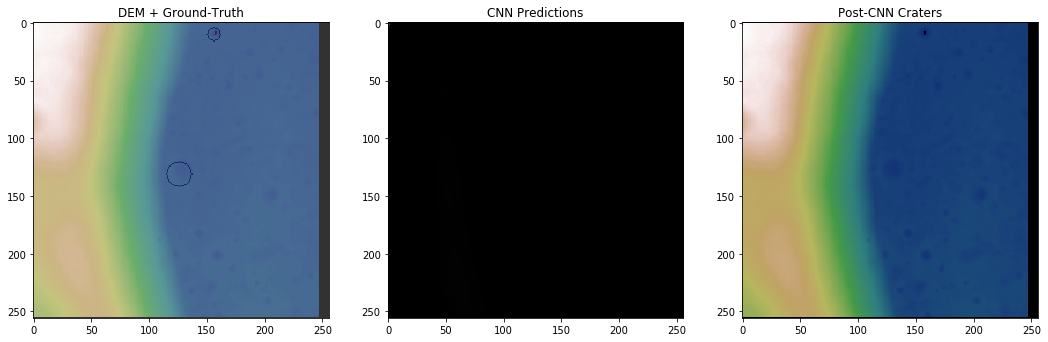

no craters were found!


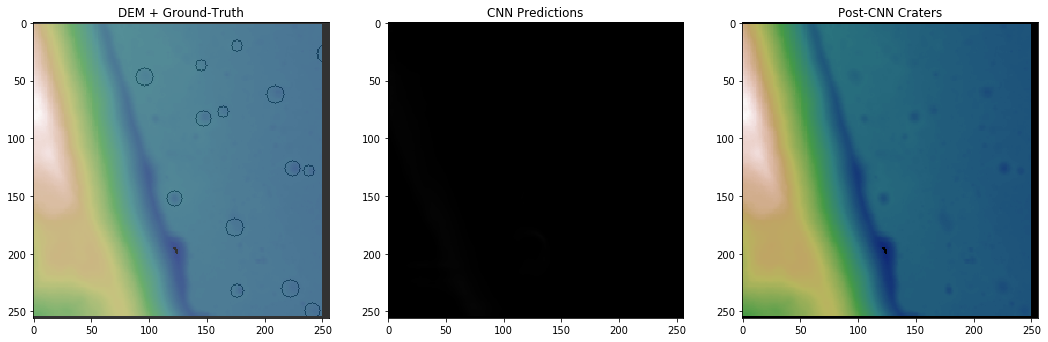

no craters were found!


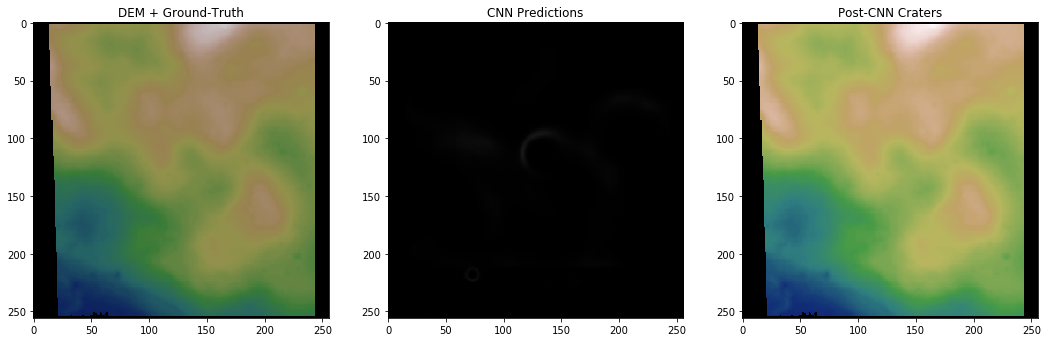

no craters were found!


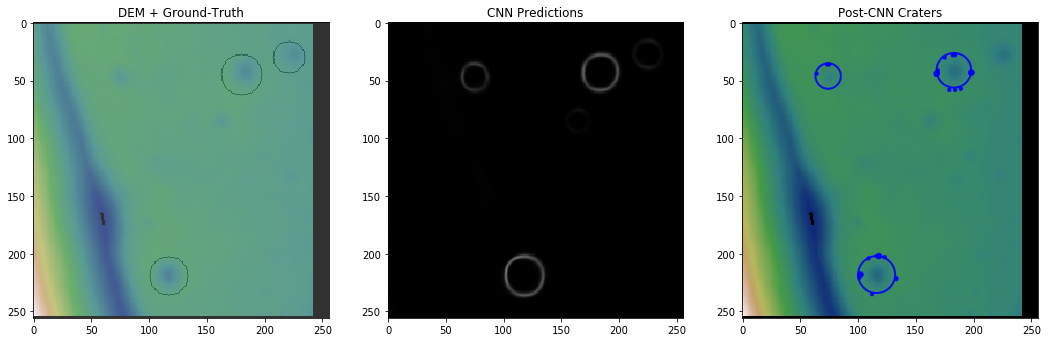

              catalog_DeepCrater  catalog_Robbins   fraction
Diameter (m)                                                
26                            25                0        inf
51                             4                0        inf
278                            1                0        inf
294                            0                1   0.000000
366                            0                1   0.000000
379                            1                0        inf
385                            0                1   0.000000
404                            1                0        inf
All                           32                3  10.666667


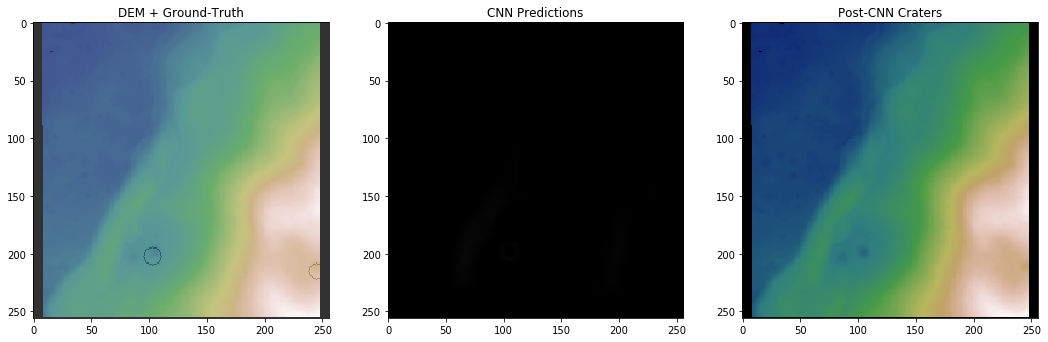

no craters were found!


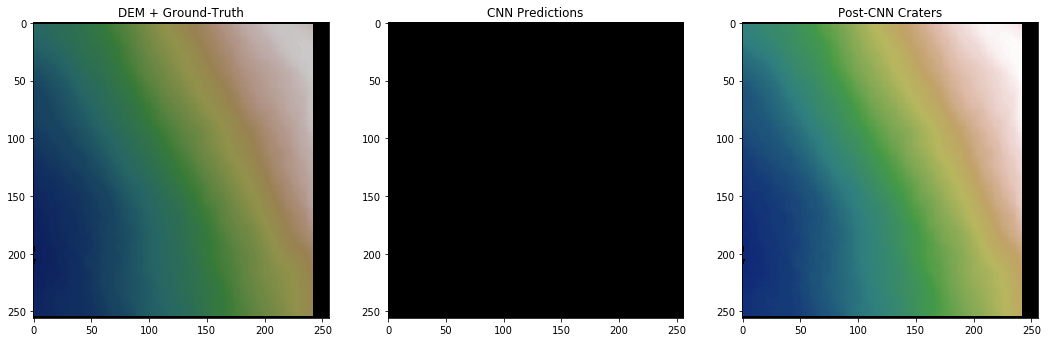

no craters were found!


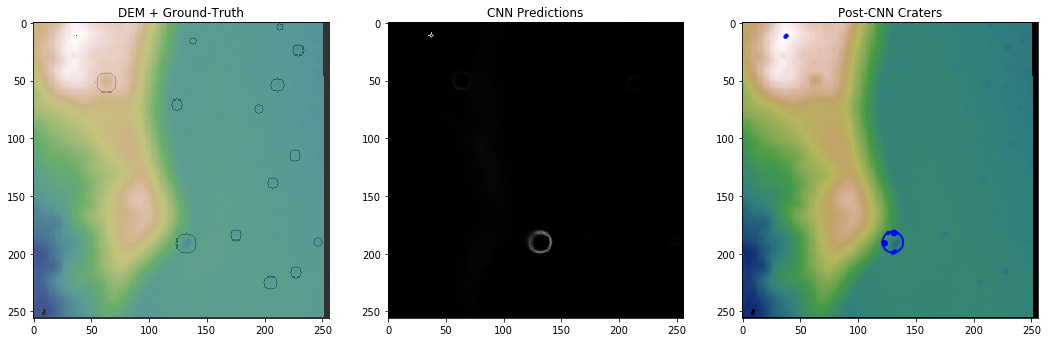

              catalog_DeepCrater  catalog_Robbins  fraction
Diameter (m)                                               
84                             9                0       inf
168                            2                0       inf
206                            0                1  0.000000
224                            0                1  0.000000
273                            0                1  0.000000
313                            0                1  0.000000
337                            0                1  0.000000
350                            0                1  0.000000
353                            0                1  0.000000
369                            0                3  0.000000
404                            0                1  0.000000
408                            0                1  0.000000
617                            0                1  0.000000
627                            0                1  0.000000
755                            1        

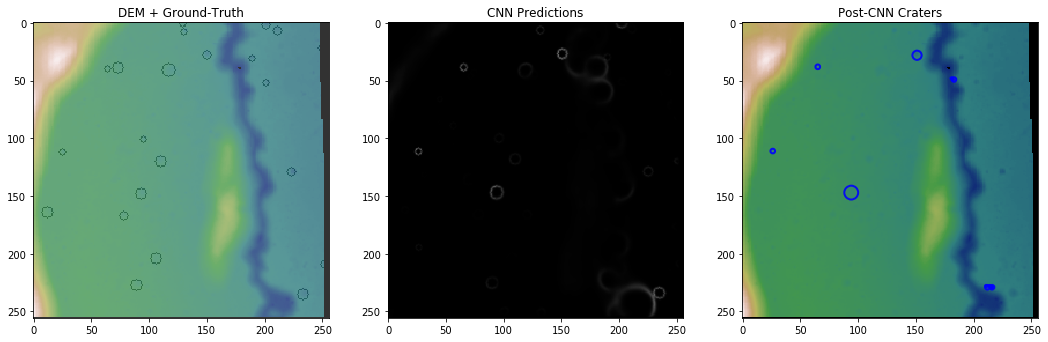

              catalog_DeepCrater  catalog_Robbins  fraction
Diameter (m)                                               
91                             6                0       inf
181                            5                0       inf
206                            0                1  0.000000
220                            0                1  0.000000
224                            0                1  0.000000
239                            0                1  0.000000
241                            0                1  0.000000
243                            0                1  0.000000
261                            0                1  0.000000
272                            0                2  0.000000
278                            0                1  0.000000
295                            0                1  0.000000
313                            0                1  0.000000
337                            0                1  0.000000
347                            0        

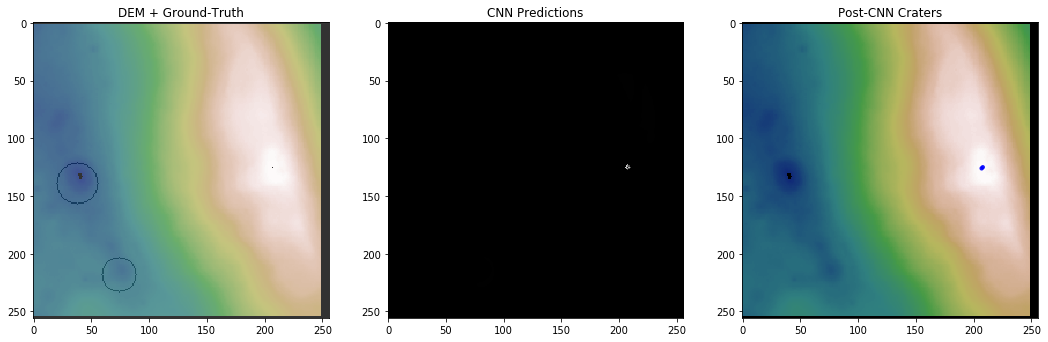

              catalog_DeepCrater  catalog_Robbins  fraction
Diameter (m)                                               
54                             2                0       inf
685                            0                1  0.000000
836                            0                1  0.000000
All                            2                2  1.000000


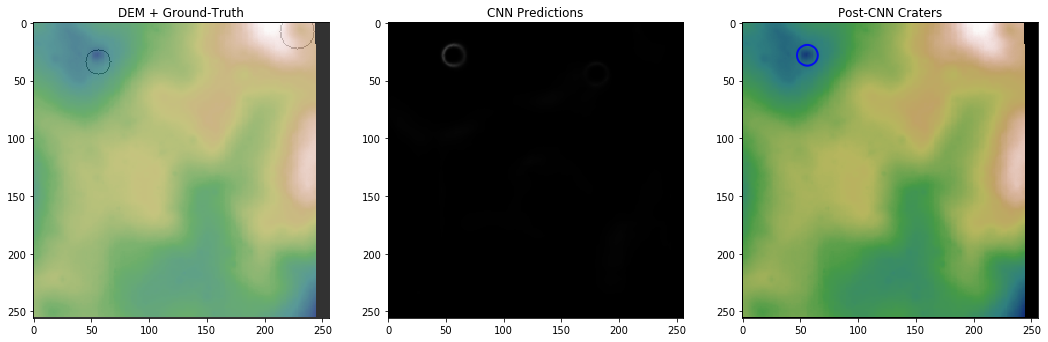

              catalog_DeepCrater  catalog_Robbins  fraction
Diameter (m)                                               
313                            1                0       inf
331                            0                1  0.000000
446                            0                1  0.000000
All                            1                2  0.500000


[None, None, None, None, None, None, None, None, None, None]

In [15]:
[predict_and_show(gen_imgs32, i, craters) for i in range(10)]

/home/grosman/projectDC/DeepCrater/technical/deep_crater_env/lib/python3.5/site-packages/skimage/feature/template.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


<IPython.core.display.Javascript object>


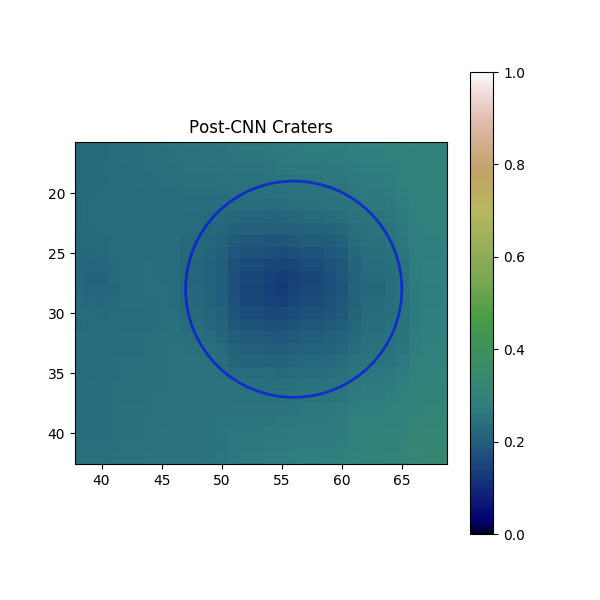

In [18]:
%matplotlib notebook
im_num=9
gen_imgs=gen_imgs32

sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
proc.preprocess(sample_data)
sd_input_images = sample_data['imgs'][0]
sd_target_masks = sample_data['imgs'][1]
pred = model.predict(sd_input_images[im_num:im_num + 1])
extracted_rings = tmt.template_match_t(pred[0].copy(), minrad=1.5)

fig = plt.figure(figsize=[6, 6])
ax1 = fig.subplots(1, 1)
plt.imshow(sd_input_images[im_num].squeeze(), origin='upper', cmap="gist_earth", vmin=0., vmax=1)
plt.colorbar()
for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.6)
    ax1.add_artist(circle)
ax1.set_title('Post-CNN Craters')

# plt.xlim((135,155))
# plt.ylim((230,250))
plt.show()


Smallest frames only: 

In [19]:
img = Image.open(data_path + fn_pre + '.TIF')
np.random.seed(42)
# Import crater catalogs (stored under /catalogues)
craters = igen.ReadRobbinsCraterCSV(filename="../catalogues/RobbinsLunarCraters.csv")

fn = data_path + 'test_LROC_32bit_small'
# sub_cdim = [350.8, 351.1, source_cdim[2], source_cdim[3]]

# Sample subset of image.  Co-opt igen.ResampleCraters to remove all
# craters beyond cdim (either sub or source).
if sub_cdim != source_cdim:
    img = igen.InitialImageCut(img, source_cdim, sub_cdim)
craters = igen.ResampleCraters(craters, sub_cdim, img.size[1])
craters.tail()
start_time = time.time()

# Generate input images: 
igen.GenDataset(img, craters, fn, 
                 cdim=sub_cdim, amt=10, rawlen_range=[256, 256], seed=42, verbose=True,
               compress32bit=True)

print("Time elapsed: {0:.1f} sec".format(time.time() - start_time))

Generating img_00
Generating img_01
Generating img_02
Generating img_03
Generating img_04
Generating img_05
Generating img_06
Generating img_07
Generating img_08
Generating img_09
Time elapsed: 2.7 sec


<IPython.core.display.Javascript object>


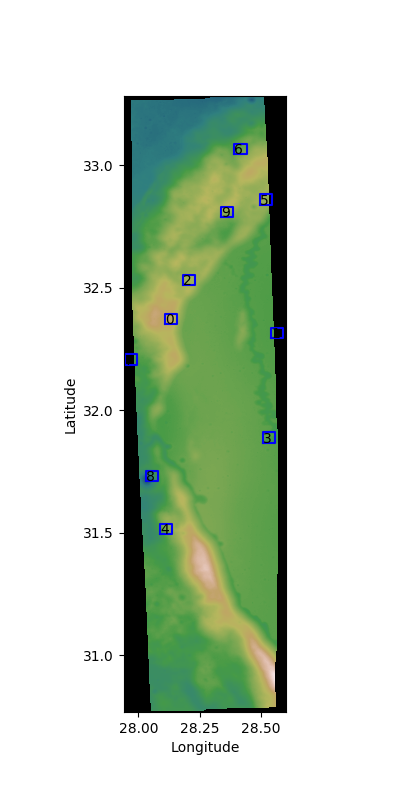

In [22]:
# See frames of the set we produced: 
gen_imgs = h5py.File(data_path + 'test_LROC_32bit_small' + '_images.hdf5', 'r')
# subset_list = np.arange(10)
fig = plt.figure(figsize=[4, 8])
dem_map = plt.imshow(img, extent=sub_cdim, aspect="equal", cmap="gist_earth", vmin=-3500, vmax=-1500)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
for i in range(10):
  llon,rlon,llat,ulat=gen_imgs['longlat_bounds']['img_{:02d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'b')
  plt.text(llon,llat,str(i), color='k')

/home/grosman/projectDC/DeepCrater/technical/deep_crater_env/lib/python3.5/site-packages/skimage/feature/template.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


<IPython.core.display.Javascript object>


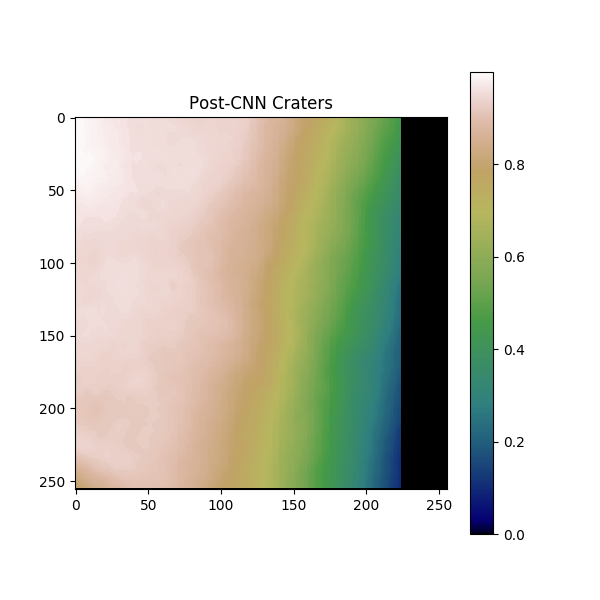

<IPython.core.display.Javascript object>


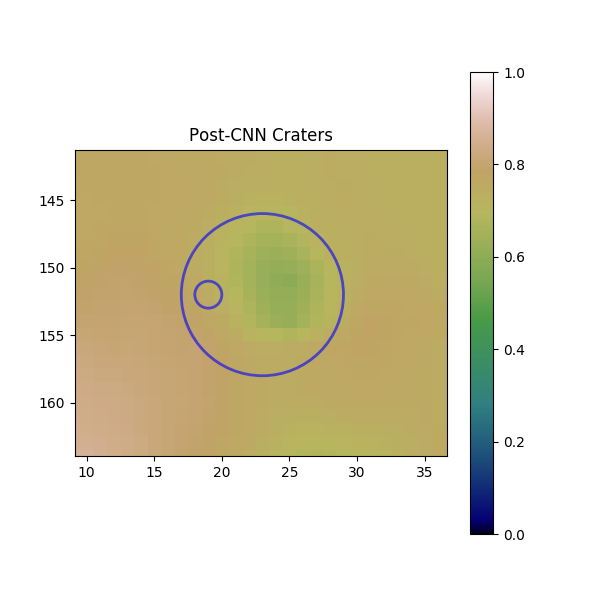

<IPython.core.display.Javascript object>


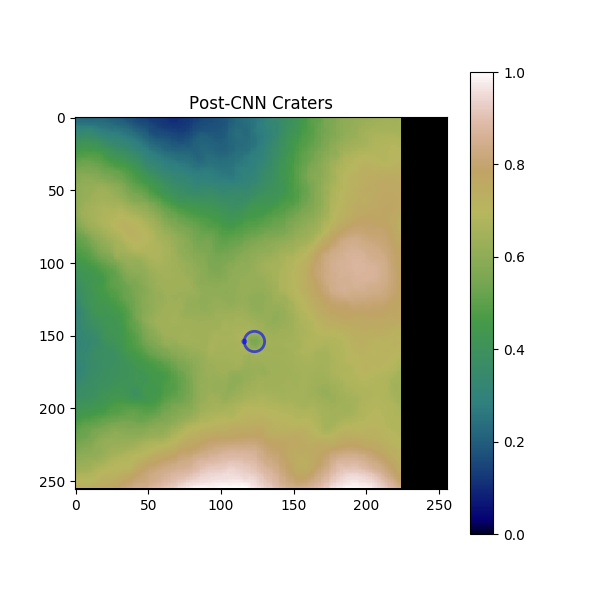

<IPython.core.display.Javascript object>


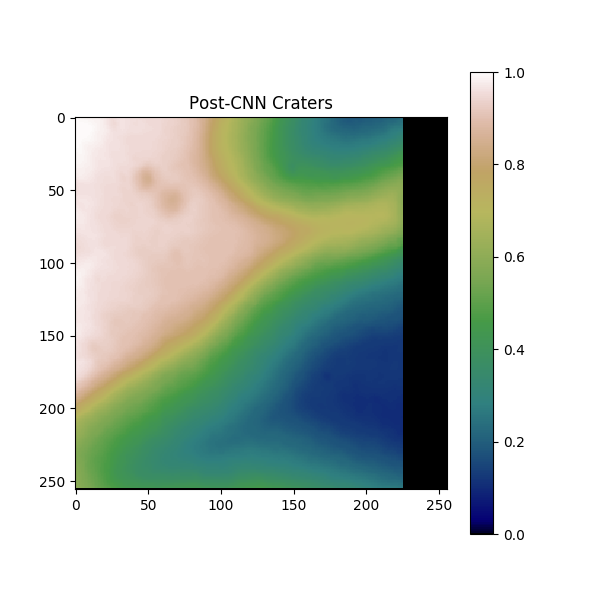

<IPython.core.display.Javascript object>


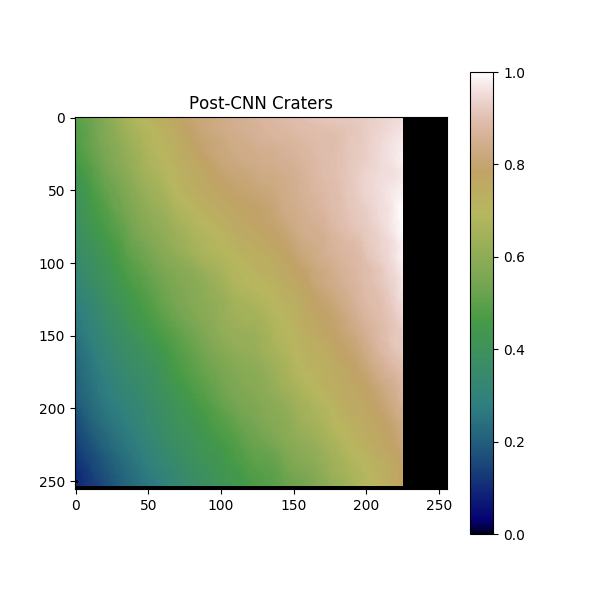

<IPython.core.display.Javascript object>


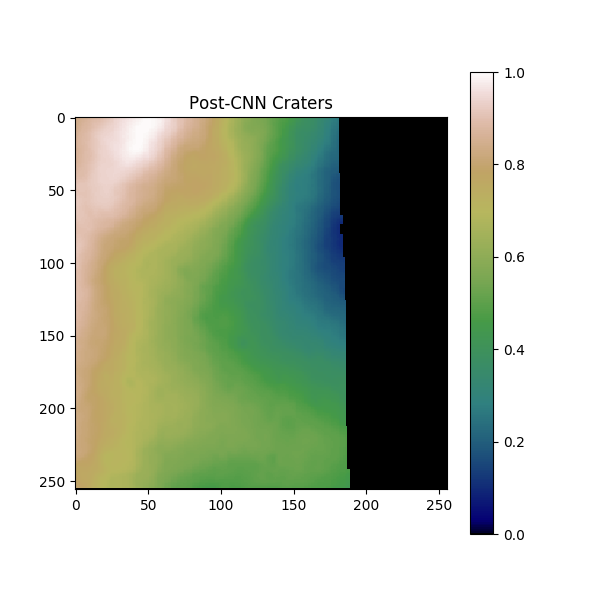

<IPython.core.display.Javascript object>


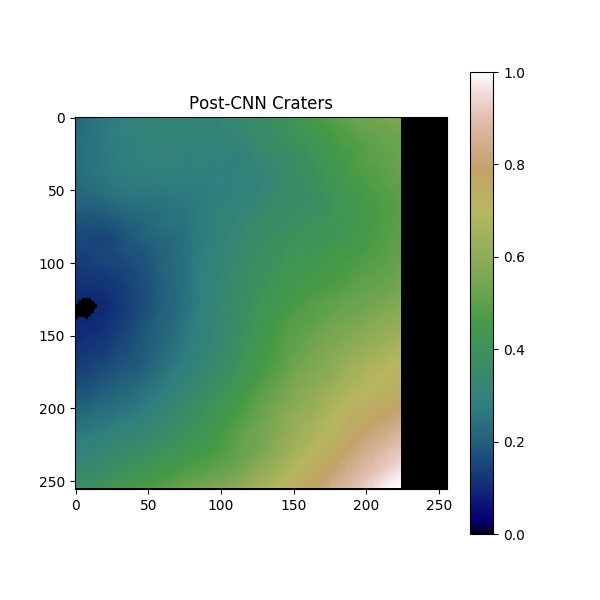

<IPython.core.display.Javascript object>


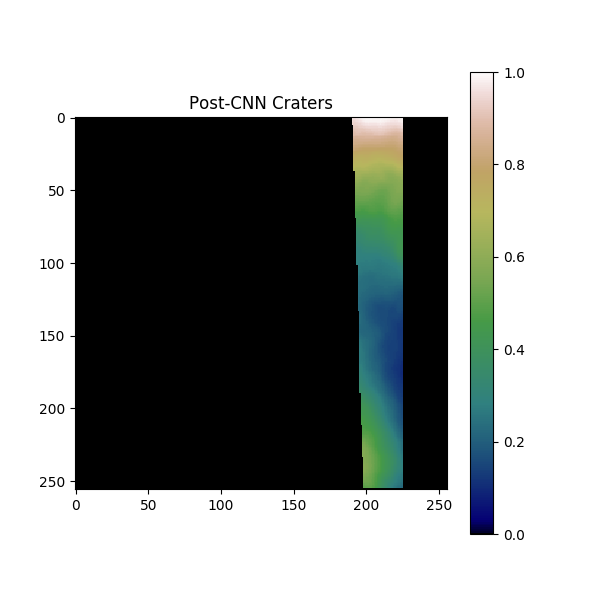

<IPython.core.display.Javascript object>


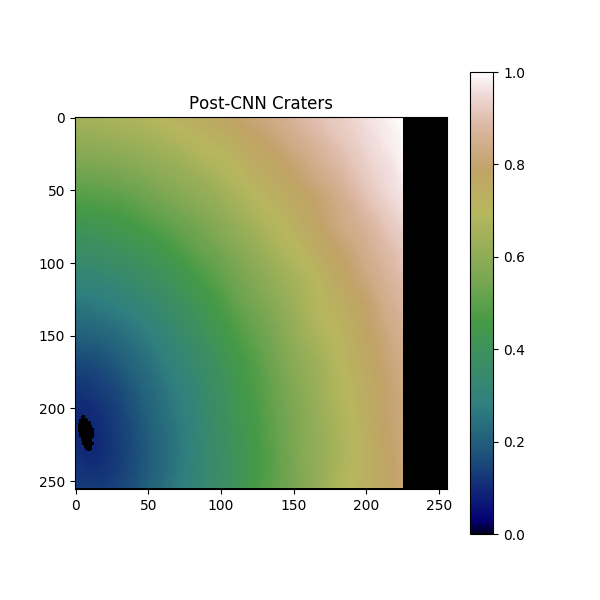

<IPython.core.display.Javascript object>


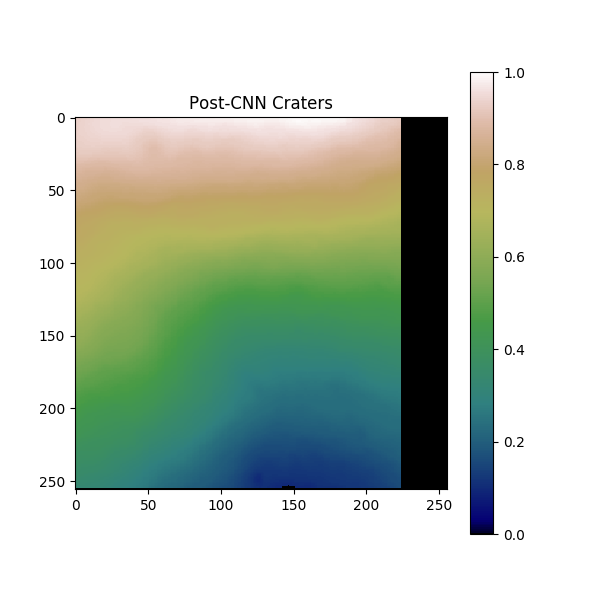

In [23]:
sub_cdim = source_cdim
%matplotlib notebook
# im_num=2

sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
proc.preprocess(sample_data)
sd_input_images = sample_data['imgs'][0]
sd_target_masks = sample_data['imgs'][1]
pred = model.predict(sd_input_images[0:10])

for i in range(10):
    extracted_rings = tmt.template_match_t(pred[i].copy(), minrad=1.5)
    fig = plt.figure(figsize=[6, 6])
    ax1 = fig.subplots(1, 1)
    plt.imshow(sd_input_images[i].squeeze(), origin='upper', cmap="gist_earth")#, vmin=0.2, vmax=0.5)
    plt.colorbar()
    for x, y, r in extracted_rings:
        circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.6)
        ax1.add_artist(circle)
    ax1.set_title('Post-CNN Craters')

    # plt.xlim((135,155))
    # plt.ylim((230,250))
    plt.show()


In [ ]:
%who